In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

<module 'libs.models' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import pandas as pd
import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import seaborn as sns
from pprint import pprint

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])

from tqdm.auto import tqdm

import io
import os
import json
from PIL import Image
import IPython.display as disp

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage

In [3]:
df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
df_trainval

,atr_ratio,atr_ratio_sma,vol_15,bb_width_20,r_5,r_15,rsi,stoch_d_3,stoch_k_14,hour,eng_adx,eng_obv,eng_ma,bid,ask,signal,pred_signal,close_mid
2004-01-02 14:07:00,-0.971426,-0.960594,-1.014295,-0.815439,-0.067706,-0.120566,-2.476841,-1.585648,-1.552562,0.263,-2.981712,-0.861562,-0.001209,0.762693,0.763836,1.000000,0.149151,0.763265
2004-01-02 14:08:00,-0.971405,-0.960547,-1.014295,-0.815436,-0.067708,-0.120569,-2.476841,-1.585648,-1.552562,0.263,-2.981712,-0.875888,-0.001209,0.762676,0.763819,1.000000,0.148588,0.763248
2004-01-02 14:09:00,-0.971384,-0.960503,-1.014295,-0.815434,-0.067709,-0.120571,-2.476841,-1.585648,-1.552562,0.263,-2.981712,-0.890215,-0.001209,0.762660,0.763802,1.000000,0.148033,0.763231
2004-01-02 14:10:00,-0.971366,-0.960462,-1.014295,-0.815431,-0.067711,-0.120574,-2.476841,-1.585648,-1.552562,0.263,-2.981712,-0.904541,-0.001209,0.762643,0.763786,1.000000,0.147489,0.763214
2004-01-02 14:11:00,-0.923613,-0.958038,-0.768664,-0.799708,0.288413,0.090469,0.776847,-1.236847,-0.528223,0.263,0.889356,-0.731059,-0.001209,0.763071,0.764215,1.000000,0.146952,0.763643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28 20:56:00,-0.030164,-0.214860,0.189349,-0.261620,1.428264,0.648909,0.631314,0.927657,1.224401,-0.941,-0.027995,0.178939,2.227838,175.238500,175.501500,0.148736,0.324245,175.370000
2022-03-28 20:57:00,-0.026538,-0.202050,0.178457,-0.130963,1.768150,0.788302,0.754476,1.199615,1.302253,-0.941,-0.019207,0.300146,4.171111,175.316000,175.579200,0.148383,0.435784,175.447600
2022-03-28 20:58:00,-0.021015,-0.188697,0.194997,0.077383,1.705393,1.050869,0.947666,1.354806,1.451027,-0.941,0.040347,0.438921,6.571623,175.453300,175.716700,0.147892,0.532184,175.585000
2022-03-28 20:59:00,0.020089,-0.173398,0.194389,0.237859,1.217749,1.112840,0.954325,1.379467,1.296826,-0.941,0.116959,0.758549,8.457740,175.458300,175.721700,0.147240,0.621951,175.590000


In [4]:
# Pre-compute per-day slices once
groups = list(df_trainval.groupby(df_trainval.index.normalize()))

def objective(trial: optuna.Trial) -> float:
    """
    Optuna objective:
      1) Suggest pred_threshold, trailing_stop_pred, smoothing_window
      2) For each day:
         a) Causally smooth `pred_signal` over the last `smoothing_window` minutes
         b) Generate discrete actions on the smoothed signal
         c) Run 1‐day backtest, collect P&L
      3) Report daily P&L for pruning, return average daily P&L
    """

    print('Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......')
    
    smoothing_window   = trial.suggest_categorical("smoothing_window", [1])
    pred_threshold     = trial.suggest_float("pred_threshold",     0.10, 0.80)
    trailing_stop_pred = trial.suggest_float("trailing_stop_pred", 0.01, 0.08)

    daily_pnls: List[float] = []

    print('')
    for step, (day, df_day) in enumerate(
        tqdm(groups, desc=f"Trial {trial.number}", leave=False), 1
    ):
        # Causal smoothing of the raw pred_signal
        df_proc = df_day.copy()
        df_proc["pred_signal_smoothed"] = (
            df_proc["pred_signal"]
              .rolling(window=smoothing_window, min_periods=1)
              .mean()
        )

        # Generate actions on the smoothed column
        df_actions = trades.generate_trade_actions(
            df                = df_proc,
            col_signal        = "pred_signal_smoothed",
            col_action        = "pred_action",
            buy_threshold     = pred_threshold,
            trailing_stop_pct = trailing_stop_pred,
            sess_start        = params.sess_start,
            col_close         = "close_mid",
        )

        # Simulate 1-day P&L
        sim = trades.simulate_trading(
            results_by_day_sign = {day.date(): (df_actions, [])},
            col_action          = "pred_action",
            sess_start          = params.sess_start,
            sess_end            = params.sess_end
        )
        _, _, stats = next(iter(sim.values()))
        daily_pnls.append(stats["Strategy Return ($)"])

        # Explicitly delete large locals at the end of each trial
        del df_proc, df_actions, sim, stats
        gc.collect()
        torch.cuda.empty_cache()

        # Rreport for pruning
        trial.report(daily_pnls[-1], step)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # Average daily P&L
    return float(np.mean(daily_pnls))


[I 2025-09-08 21:07:22,918] A new study created in RDB with name: no-name-05b84bca-75d3-4d60-875a-8fbad274a2cf


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 0:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-08 21:27:36,523] Trial 0 finished with value: -0.07353452406883033 and parameters: {'smoothing_window': 59, 'pred_threshold': 0.18242062486349273, 'trailing_stop_pred': 0.06652638272391301}. Best is trial 0 with value: -0.07353452406883033.


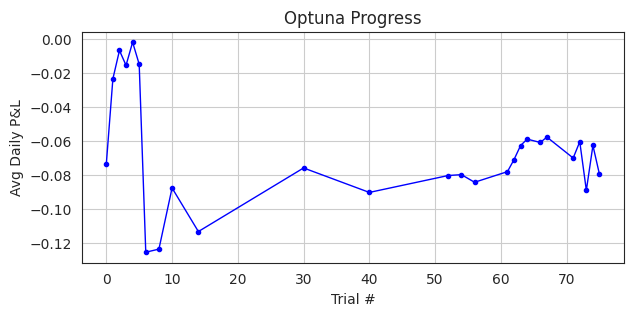

Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 1:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-08 21:46:38,220] Trial 1 finished with value: -0.0233106077107384 and parameters: {'smoothing_window': 52, 'pred_threshold': 0.5394702516024457, 'trailing_stop_pred': 0.05324601900447869}. Best is trial 1 with value: -0.0233106077107384.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 2:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-08 22:08:38,754] Trial 2 finished with value: -0.006636244826835114 and parameters: {'smoothing_window': 48, 'pred_threshold': 0.735178478209677, 'trailing_stop_pred': 0.04257608590930402}. Best is trial 2 with value: -0.006636244826835114.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 3:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-08 22:30:52,287] Trial 3 finished with value: -0.015382923110433456 and parameters: {'smoothing_window': 18, 'pred_threshold': 0.7727538940979046, 'trailing_stop_pred': 0.06788509062592231}. Best is trial 2 with value: -0.006636244826835114.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 4:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-08 22:49:33,885] Trial 4 finished with value: -0.0017728163798736661 and parameters: {'smoothing_window': 58, 'pred_threshold': 0.7832934755550622, 'trailing_stop_pred': 0.06718003552847071}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 5:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-08 23:08:07,068] Trial 5 finished with value: -0.01473469832280549 and parameters: {'smoothing_window': 60, 'pred_threshold': 0.5786935715388957, 'trailing_stop_pred': 0.05848112624963474}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 6:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-08 23:25:26,065] Trial 6 finished with value: -0.12550381180570683 and parameters: {'smoothing_window': 16, 'pred_threshold': 0.40566989093323447, 'trailing_stop_pred': 0.04379303701498723}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 7:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-08 23:28:05,727] Trial 7 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 8:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-08 23:45:24,294] Trial 8 finished with value: -0.12367174907427576 and parameters: {'smoothing_window': 17, 'pred_threshold': 0.1395082963705655, 'trailing_stop_pred': 0.06800244419452538}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 9:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-08 23:48:04,936] Trial 9 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 10:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:05:20,510] Trial 10 finished with value: -0.08765410585928991 and parameters: {'smoothing_window': 34, 'pred_threshold': 0.3620892382357629, 'trailing_stop_pred': 0.02129657685438582}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 11:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:07:07,419] Trial 11 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 12:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:08:55,518] Trial 12 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 13:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:11:37,943] Trial 13 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 14:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:28:56,311] Trial 14 finished with value: -0.11332106294924851 and parameters: {'smoothing_window': 31, 'pred_threshold': 0.27554802953371144, 'trailing_stop_pred': 0.012576950944335766}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 15:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:30:43,094] Trial 15 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 16:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:32:30,654] Trial 16 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 17:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:36:07,284] Trial 17 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 18:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:37:54,993] Trial 18 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 19:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:40:36,628] Trial 19 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 20:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:42:23,718] Trial 20 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 21:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:44:11,083] Trial 21 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 22:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:46:52,682] Trial 22 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 23:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:48:40,368] Trial 23 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 24:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:51:21,541] Trial 24 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 25:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:53:09,304] Trial 25 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 26:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:54:57,655] Trial 26 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 27:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:56:45,848] Trial 27 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 28:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 00:59:27,672] Trial 28 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 29:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 01:03:05,024] Trial 29 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 30:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 01:20:35,004] Trial 30 finished with value: -0.07585972554998911 and parameters: {'smoothing_window': 58, 'pred_threshold': 0.25518262401631164, 'trailing_stop_pred': 0.06347461404293288}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 31:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 01:22:23,146] Trial 31 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 32:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 01:24:11,719] Trial 32 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 33:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 01:25:59,049] Trial 33 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 34:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 01:27:47,779] Trial 34 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 35:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 01:29:35,436] Trial 35 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 36:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 01:31:23,555] Trial 36 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 37:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 01:33:12,867] Trial 37 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 38:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 01:35:01,192] Trial 38 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 39:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 01:36:50,545] Trial 39 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 40:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 01:54:31,185] Trial 40 finished with value: -0.09027031147898062 and parameters: {'smoothing_window': 12, 'pred_threshold': 0.10044227039769499, 'trailing_stop_pred': 0.04285392852389115}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 41:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 01:56:20,782] Trial 41 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 42:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 01:58:10,937] Trial 42 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 43:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 02:00:00,369] Trial 43 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 44:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 02:01:50,343] Trial 44 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 45:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 02:03:39,585] Trial 45 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 46:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 02:05:28,237] Trial 46 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 47:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 02:07:18,555] Trial 47 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 48:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 02:09:08,537] Trial 48 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 49:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 02:10:57,501] Trial 49 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 50:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 02:12:47,967] Trial 50 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 51:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 02:14:37,759] Trial 51 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 52:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 02:32:19,155] Trial 52 finished with value: -0.08030668699629712 and parameters: {'smoothing_window': 54, 'pred_threshold': 0.23291853777000338, 'trailing_stop_pred': 0.07079636515772303}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 53:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 02:34:08,994] Trial 53 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 54:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 02:51:50,961] Trial 54 finished with value: -0.07979350903942496 and parameters: {'smoothing_window': 56, 'pred_threshold': 0.20285778886511496, 'trailing_stop_pred': 0.07682803386398177}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 55:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 02:53:39,967] Trial 55 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 56:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 03:11:27,425] Trial 56 finished with value: -0.08428534088433891 and parameters: {'smoothing_window': 45, 'pred_threshold': 0.16650542747814703, 'trailing_stop_pred': 0.060191485628972745}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 57:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 03:13:17,807] Trial 57 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 58:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 03:15:08,664] Trial 58 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 59:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 03:16:57,795] Trial 59 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 60:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 03:18:47,444] Trial 60 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 61:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 03:36:30,953] Trial 61 finished with value: -0.07803267262034413 and parameters: {'smoothing_window': 58, 'pred_threshold': 0.2174474918631003, 'trailing_stop_pred': 0.06312201365729526}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 62:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 03:54:21,193] Trial 62 finished with value: -0.07094794162491833 and parameters: {'smoothing_window': 57, 'pred_threshold': 0.15518168968176643, 'trailing_stop_pred': 0.06569028531530909}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 63:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 04:12:08,493] Trial 63 finished with value: -0.06264169026355915 and parameters: {'smoothing_window': 50, 'pred_threshold': 0.12601599470185382, 'trailing_stop_pred': 0.057628806240532154}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 64:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 04:29:57,863] Trial 64 finished with value: -0.058869309518623396 and parameters: {'smoothing_window': 50, 'pred_threshold': 0.1126806282823889, 'trailing_stop_pred': 0.05781715184463083}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 65:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 04:31:48,948] Trial 65 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 66:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 04:49:36,343] Trial 66 finished with value: -0.060836854715748206 and parameters: {'smoothing_window': 50, 'pred_threshold': 0.11982194967661547, 'trailing_stop_pred': 0.04722509301635718}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 67:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 05:07:30,600] Trial 67 finished with value: -0.057664778915269 and parameters: {'smoothing_window': 38, 'pred_threshold': 0.1010198313545709, 'trailing_stop_pred': 0.04720214383241497}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 68:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 05:09:20,105] Trial 68 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 69:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 05:25:30,999] Trial 69 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 70:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 05:27:19,659] Trial 70 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 71:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 05:45:16,113] Trial 71 finished with value: -0.07001023742104116 and parameters: {'smoothing_window': 39, 'pred_threshold': 0.12326817216768828, 'trailing_stop_pred': 0.047190073066464076}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 72:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 06:03:12,070] Trial 72 finished with value: -0.06040622957961228 and parameters: {'smoothing_window': 37, 'pred_threshold': 0.10435893905695352, 'trailing_stop_pred': 0.040562942340646606}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 73:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 06:21:04,988] Trial 73 finished with value: -0.08903397952515793 and parameters: {'smoothing_window': 34, 'pred_threshold': 0.14862830912231734, 'trailing_stop_pred': 0.04038703040569155}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 74:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 06:39:02,510] Trial 74 finished with value: -0.06261380962753213 and parameters: {'smoothing_window': 36, 'pred_threshold': 0.10589217625115849, 'trailing_stop_pred': 0.033923615878805255}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 75:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 06:56:51,119] Trial 75 finished with value: -0.07968743193204095 and parameters: {'smoothing_window': 41, 'pred_threshold': 0.1425151875421747, 'trailing_stop_pred': 0.03785934302551768}. Best is trial 4 with value: -0.0017728163798736661.


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 76:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 06:58:40,239] Trial 76 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 77:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 07:06:30,595] Trial 77 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 78:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 07:08:20,094] Trial 78 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 79:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 07:10:10,882] Trial 79 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 80:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-09 07:12:02,023] Trial 80 pruned. 


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 81:   0%|          | 0/4591 [00:00<?, ?it/s]

[W 2025-09-09 07:23:05,953] Trial 81 failed with parameters: {'smoothing_window': 49, 'pred_threshold': 0.113757400574168, 'trailing_stop_pred': 0.04869118617321089} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_2085/3449028383.py", line 63, in objective
    if trial.should_prune():
       ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/optuna/trial/_trial.py", line 539, in should_prune
    return self.study.pruner.prune(self.study, trial)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/optuna/pruners/_percentile.py", line 190, in prune
    if not _is_first_in_interval_step(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/optuna/pruners/_percent

KeyboardInterrupt: 

In [5]:
n_trials = 500
n_jobs = 1

pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=500)

study = optuna.create_study( # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    storage=f"sqlite:///{os.path.join(params.optuna_folder, "optuna_study_predicted.db")}", 
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback, plots.save_results_callback],
    gc_after_trial    = True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

In [ ]:
# Final plots & JSON dump 
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df_trainval.index.normalize().min().strftime("%Y%m%d")
last_day  = df_trainval.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{first_day}-{last_day}_optuna_predicted_{study.best_value}_{params.model_path}.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")